<a href="https://colab.research.google.com/github/ThumbRocket/Pre-Learning_AI_Model/blob/main/4_CNN_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import sys
import nbformat
import json
import subprocess
import re
from nbconvert.preprocessors import ExecutePreprocessor
from nbclient import NotebookClient
from IPython import get_ipython
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
!kaggle datasets download -d alexandremoritz/simulated-analog-wafer-pattern-recognition
!unzip -o simulated-analog-wafer-pattern-recognition.zip

df = pd.DataFrame()
all_images=[]
all_labels=[]
test_images = []
test_labels = []

for i in range(1, 5):
    tmp_df = pd.read_csv("training_"+str(i)+".csv",
                         sep=";",
                         decimal=",",
                         usecols=["lot", "wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"],
                         dtype={
                             "lot":np.string_,
                             "wafer":np.int16,
                             "x":np.int16,
                             "y":np.int16,
                             "ring":np.float64,
                             "spot":np.float64,
                             "trend":np.float64,
                             "twospot":np.float64,
                             "cresent":np.float64}
                         )

    df = pd.concat([df, tmp_df])

test_df = pd.read_csv("test.csv",
                        sep=";",
                        decimal=",",
                        usecols=["lot", "wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"],
                        dtype={
                            "lot":np.string_,
                            "wafer":np.int16,
                            "x":np.int16,
                            "y":np.int16,
                            "ring":np.float64,
                            "spot":np.float64,
                            "trend":np.float64,
                            "twospot":np.float64,
                            "cresent":np.float64}
                        )

category = df.columns[4:].to_list()

def create_image(df, wafer_id, pattern):

    Image =np.zeros([193, 115])

    for i, row in df[df["wafer"]==wafer_id].iterrows():
        Image[(row["y"]-1), row["x"]-1] = row[pattern]

    return Image

def create_images_from_df(df, wafer_id):

    images=[]
    labels=[]

    for index, feature in enumerate(category):
        image = np.copy(df[df["wafer"]==wafer_id].pivot(index="x", columns="y", values=feature).fillna(0).values)
        images.append(image)
        labels.append(index)

    return images, labels

for id in tqdm(df["wafer"].unique()):
    image, label = create_images_from_df(df, id)

    all_images.extend(image)
    all_labels.extend(label)

for id in tqdm(test_df["wafer"].unique()):
    image, label = create_images_from_df(test_df, id)

    test_images.extend(image)
    test_labels.extend(label)

df_loaded = pd.DataFrame({"image" : all_images, "label" : all_labels})
test_df_loaded = pd.DataFrame({"image" : test_images, "label" : test_labels})

Dataset URL: https://www.kaggle.com/datasets/alexandremoritz/simulated-analog-wafer-pattern-recognition
License(s): Attribution 4.0 International (CC BY 4.0)
simulated-analog-wafer-pattern-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  simulated-analog-wafer-pattern-recognition.zip
  inflating: Data Set Description.txt  
  inflating: test.csv                
  inflating: training_1.csv          
  inflating: training_2.csv          
  inflating: training_3.csv          
  inflating: training_4.csv          


100%|██████████| 200/200 [00:10<00:00, 19.32it/s]


In [4]:
train_df, val_df = train_test_split(df_loaded, test_size=0.20, random_state=42, stratify=df_loaded["label"])

In [5]:
train_df.shape, val_df.shape, test_df_loaded.shape

((3200, 2), (800, 2), (1000, 2))

In [6]:
def minmax_scaling(image):
    min_val = torch.min(image)
    max_val = torch.max(image)

    if max_val - min_val < 1e-9:
        return image
    else:
        return (image - min_val) / (max_val - min_val)

base_transform = transforms.Compose([
    transforms.Lambda(minmax_scaling),
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    base_transform,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

transform = {
    "train" : train_transform,
    "test" : base_transform
}

In [7]:
class WaferDataset(Dataset):
    def __init__(self, dataframe, mode='train',transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.tensor(self.dataframe.iloc[idx, 0]).float()
        label = torch.tensor(self.dataframe.iloc[idx, 1]).long()

        if self.transform:
            image = self.transform[self.mode](image)

        return image, label

In [8]:
train_dataset = WaferDataset(train_df, mode='train', transform=transform)
val_dataset = WaferDataset(val_df, mode='test', transform=transform)
test_dataset = WaferDataset(test_df_loaded, mode='test', transform=transform)

In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3200, 800, 1000)

In [10]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully-Connected Layer
        self.fc1 = nn.Linear(64 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 5)

    def forward(self, x):
        # Block 1 (input 96x96)
        x = F.relu(self.conv1_1(x)) # 16x96x96
        x = F.relu(self.conv1_2(x)) # 16x96x96
        x = self.bn1(x)             # 16x96x96
        x = self.pool1(x)           # 16x48x48

        # Block 2
        x = F.relu(self.conv2_1(x)) # 32x48x48
        x = F.relu(self.conv2_2(x)) # 32x48x48
        x = self.bn2(x)             # 32x48x48
        x = self.pool2(x)           # 32x24x24

        # Block 3
        x = F.relu(self.conv3_1(x)) # 64x24x24
        x = F.relu(self.conv3_2(x)) # 64x24x24
        x = self.bn3(x)             # 64x24x24
        x = self.pool3(x)           # 64x12x12

        # flatter (batch_szie, 64x12X12) -> (batch_size, 9216)
        x = x.view(x.size(0), -1)   # 9216 (64x12x12)

        # Fully-Connected Layer
        x = F.relu(self.fc1(x))     # 256
        x = self.fc2(x)             # 5

        return F.softmax(x, dim=1)

In [12]:
model = VGG()

In [13]:
model = VGG()

In [14]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, save_path):

    model.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()

        total_train_loss = 0.0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item() * inputs.size(0)

                _, predicted = outputs.max(1)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / len(val_loader.dataset)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # If the current validation loss is lower than the best validation loss, save the model.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

    return model, train_losses, val_losses

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()
epochs = 5
save_path = 'CNN_VGG_checkpoint.pth'

In [16]:
trained_model, train_loss, val_loss = train_model(model,
                                                  train_loader,
                                                  val_loader,
                                                  optimizer,
                                                  criterion,
                                                  num_epochs=epochs,
                                                  device=device,
                                                  save_path=save_path)

Epoch [1/5] - Train Loss: 1.5200, Train Accuracy: 0.6431, Validation Loss: 1.4337, Validation Accuracy: 0.9437
Model saved at CNN_VGG_checkpoint.pth
Epoch [2/5] - Train Loss: 1.2905, Train Accuracy: 0.9494, Validation Loss: 1.1847, Validation Accuracy: 0.9750
Model saved at CNN_VGG_checkpoint.pth
Epoch [3/5] - Train Loss: 1.1510, Train Accuracy: 0.9769, Validation Loss: 1.0857, Validation Accuracy: 0.9862
Model saved at CNN_VGG_checkpoint.pth
Epoch [4/5] - Train Loss: 1.0697, Train Accuracy: 0.9884, Validation Loss: 1.0219, Validation Accuracy: 0.9988
Model saved at CNN_VGG_checkpoint.pth
Epoch [5/5] - Train Loss: 1.0127, Train Accuracy: 0.9966, Validation Loss: 0.9780, Validation Accuracy: 1.0000
Model saved at CNN_VGG_checkpoint.pth


In [17]:
def test_model(model, test_loader, criterion, device):

    model.eval()

    model.to(device)

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    avg_test_loss = total_loss / total
    test_accuracy = correct / total

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return avg_test_loss, test_accuracy

In [18]:
test_loss, test_accuracy = test_model(trained_model,
                                      test_loader,
                                      criterion,
                                      device=device)

print(f"Test loss: {test_loss} | Test Accuracy: {test_accuracy}")

Test Loss: 0.9792, Test Accuracy: 0.9980
Test loss: 0.9792184143066406 | Test Accuracy: 0.998


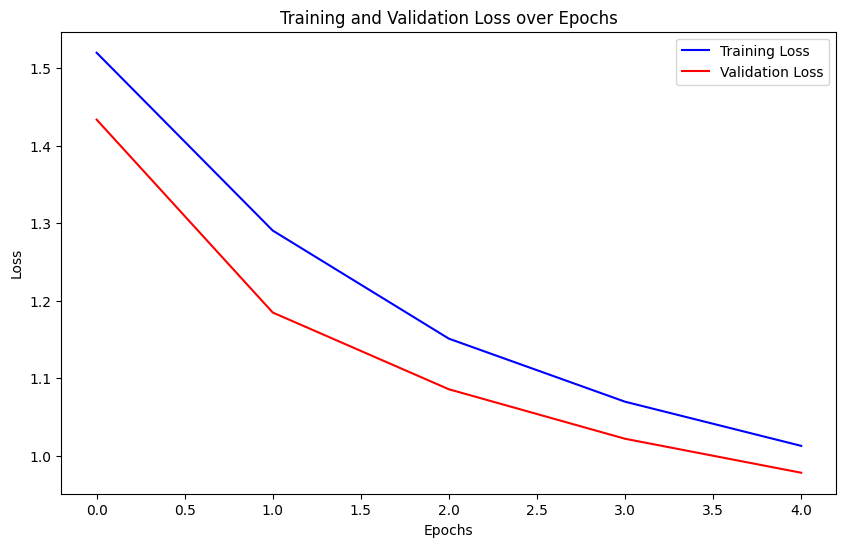

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Classification report

classification_report는 분류 작업의 성능을 평가하기 위한 주요 지표를 제공하는 함수입니다.

이 함수는 `sklearn.metrics` 모듈에 포함되어 있으며, 주로 다음지표를 포함합니다:

1. 정밀도(Precision):

    - 정밀도는 "True로 예측된 것 중에서 실제로 True인 것의 비율"을 나타냅니다.

    - 모델이 True라고 예측한 것 중에서 실제로 True인 것의 비율을 나타냅니다.

2. 재현율(Recall) 또는 민감도(Sensitivity):

    - 재현율은 "실제 True인 것 중에서 True로 예측된 것의 비율"을 나타냅니다.
    
    - 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율을 나타냅니다.

3. F1-Score (F1-Score):

    - F1-Score는 정밀도와 재현율의 조화 평균입니다.

    - 정밀도와 재현율이 모두 높을 때 F1-점수도 높아집니다.

4. 지지도(Support):

    - 지지도는 각 클래스에 속하는 실제 인스턴스의 수를 나타냅니다.

    - 예를 들어, 100개의 샘플 중 30개가 클래스 A에 속하면, 클래스 A의 지지도는 30입니다.

In [20]:
def get_predictions(model, loader, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

In [21]:
predictions, true_labels  = get_predictions(trained_model, val_loader, device)

In [22]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       160
           4       1.00      1.00      1.00       160

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

